### **Variational Physics Informed Neural Network**

In [48]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from numpy.polynomial import legendre as leg
from scipy.integrate import quad
from scipy.linalg import eigh
from scipy.interpolate import UnivariateSpline

In [2]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Método de Integración**

Cuadratura Gaussiana

In [3]:
def gauss_quad_manual(func, a, b, n):
    """
    Approximate the integral of a function using Gaussian quadrature.

    Parameters:
    func (function): The function to integrate.
    a (float): The start of the integration interval.
    b (float): The end of the integration interval.
    n (int): The number of nodes to use for the approximation.

    Returns:
    float: The approximate integral of the function over the interval [a, b].
    """    
    nodes = leg.legroots(leg.legder([0]*n + [1]))
    
    weights = 2 / ((1 - nodes**2) * (leg.legval(nodes, leg.legder([0]*(n-1) + [1], m=2)))**2)
    
    t = 0.5*(nodes + 1)*(b - a) + a
    
    integral = np.sum(weights * func(t)) * 0.5*(b - a)

    return integral

**Método de Diferenciación**

In [4]:
def central_difference(v, x):
    """
    Calculates the central difference approximation of the derivative of a function.

    Parameters:
    v (array-like): The values of the function.
    x (array-like): The corresponding x-values.

    Returns:
    array-like: The central difference approximation of the derivative.
    """
    h = x[1] - x[0]  
    dv = (v[2:] - v[:-2]) / (2*h)
    return dv

**Funciones de Test con FEM Helmholtz**

In [78]:
def FEM1D(coords):
    N = len(coords)
    stiff_loc = np.array([[2.0, -2.0],
                          [-2.0, 2.0]])
    mass_loc = np.array([[2/3, 1/3],
                         [1/3, 2/3]])
    eles = [np.array([cont, cont + 1]) for cont in range(0, N - 1)]
    stiff = np.zeros((N, N))
    mass = np.zeros((N, N))
    for ele in eles:  ## Ensamblaje
        jaco = coords[ele[1]] - coords[ele[0]]
        for cont1, row in enumerate(ele):
            for cont2, col in enumerate(ele):
                stiff[row, col] = stiff[row, col] +  stiff_loc[cont1, cont2]/jaco
                mass[row, col] = mass[row, col] +  jaco*mass_loc[cont1, cont2]
    return stiff, mass

# Caso de ejemplo
N = 100
nvals = 20
x = np.linspace(0, 1, N)

# FEM1D
stiff, mass = FEM1D(x)

# Vectores propios
vals, vecs = eigh(stiff[1:-1, 1:-1],
                  mass[1:-1, 1:-1],
                  subset_by_index=(0, nvals - 1))

vecs_comp = np.zeros((N, nvals))
vecs_comp[1:-1, :] = vecs

# Interpolación
x_eval = torch.linspace(0, 1, 1000).detach().numpy()
spline = UnivariateSpline(x, vecs_comp[:, 3], s=0)
v_eval = spline(x_eval)
v_eval = v_eval.reshape(1000, 1)
v_eval.shape 

spline_derivative = spline.derivative()
v_eval_derivative = spline_derivative(x_eval)

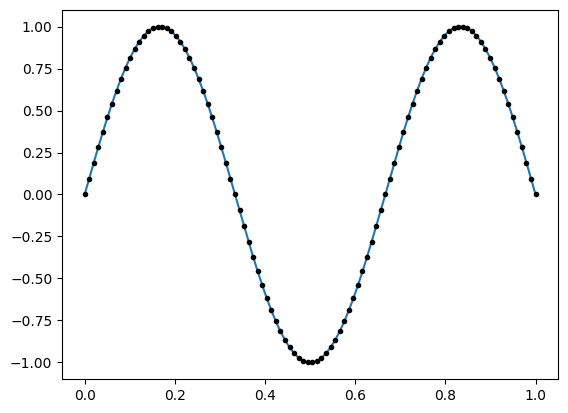

In [79]:
plt.figure()
plt.plot(x_eval, v_eval)
plt.plot(x, vecs_comp[:, 2], ".k")

Text(0.5, 1.0, 'Derivative')

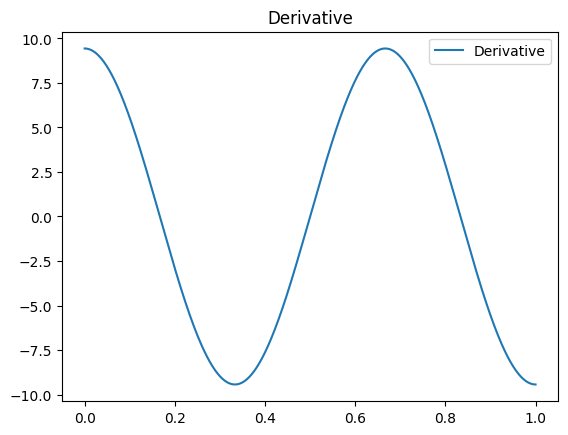

In [80]:
plt.figure()
plt.plot(x_eval, v_eval_derivative, label='Derivative')
plt.legend()
plt.title('Derivative')

**Arquitectura de Red Neuronal**

In [9]:
class FCN(nn.Module):  
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
                    nn.Sequential(*[
                        nn.Linear(N_HIDDEN, N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        a = x * (x - torch.pi)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)        
        output = torch.einsum('ij,ij->ij', a, x)
        return output

Formulación problema

In [14]:
def f_rhs(x):
  return 4*torch.sin(2 * x)

def exact_u(x):
  return torch.sin(2 * x)

**Variational Neural Network**

Variational Loss

Loss at iteration 50: 32.590965270996094
Loss at iteration 100: 19.844579696655273
Loss at iteration 150: 34.341777801513672
Loss at iteration 200: 29.404605865478516
Loss at iteration 250: 13.902945518493652
Loss at iteration 300: 23.755504608154297
Loss at iteration 350: 24.464155197143555
Loss at iteration 400: 18.477907180786133
Loss at iteration 450: 37.589260101318359
Loss at iteration 500: 42.837886810302734
Loss at iteration 550: 15.413751602172852
Loss at iteration 600: 17.885385513305664
Loss at iteration 650: 28.067207336425781
Loss at iteration 700: 17.744674682617188
Loss at iteration 750: 22.928430557250977
Loss at iteration 800: 55.840892791748047
Loss at iteration 850: 16.284788131713867
Loss at iteration 900: 23.896139144897461
Loss at iteration 950: 34.797573089599609
Loss at iteration 1000: 15.586620330810547


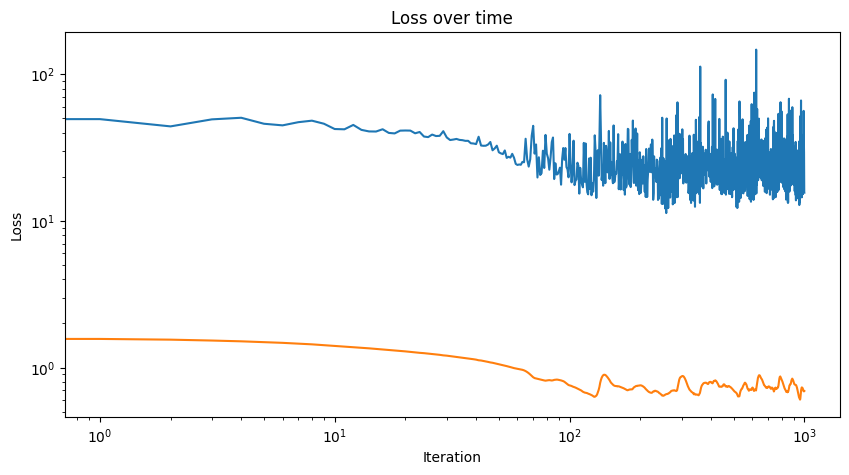

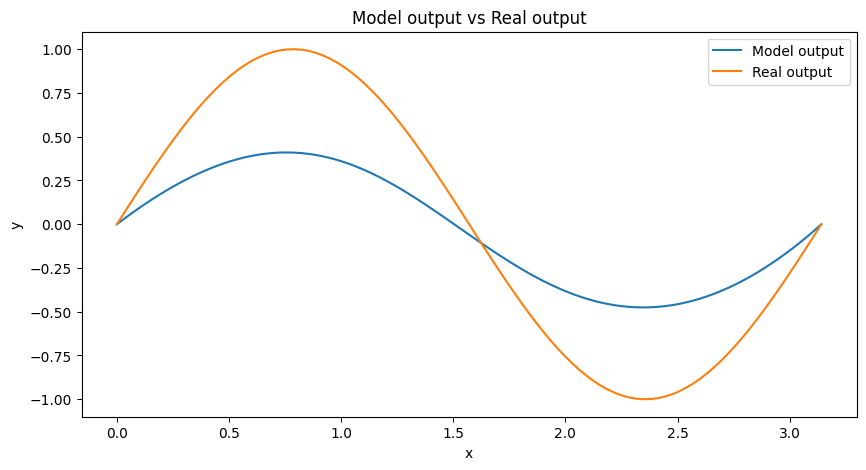

In [47]:
def compute_integral(y, x):    
    integral = torch.trapz(y, x, dim=0)
    return integral
 
def compute_loss(model, x, v):
    u = model(x)
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0] 
    
    dvs = list()
    for mode in v.T:
        dv = torch.autograd.grad(mode.sum(), x, create_graph=True)[0]
        dvs.append(dv)        
    dvs = torch.stack(dvs)
        
    f_rhs_val = f_rhs(x)    
    integral_left = compute_integral(torch.einsum('jl,kjl->jk',du,dvs),x)    
    integral_right = compute_integral(torch.einsum('jl,jk->jk',f_rhs_val,v), x)

    error_PDE = (integral_left - integral_right)**2    
    loss = error_PDE.sum()

    return loss

def compute_L2_error(model, x, exact_u):
    exact_function = exact_u(x)
    predicted_function = model(x).detach()

    error_between_arrays = exact_function - predicted_function
    delta_x = x[1:] - x[:-1]

    L2_error = (error_between_arrays[:-1] + error_between_arrays[1:]) / 2 
    L2_output = torch.sqrt(torch.sum(delta_x * (L2_error**2)))
    return L2_output.item()

def main():
    N_modes = 20
    n_pts = 100
    iterations = 1000

    torch.manual_seed(123)
    model = FCN(1, 1, 10, 4)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    L2_errors = []    
    
    n = torch.linspace(1, N_modes, N_modes)  

    for i in range(iterations):

        random_points = torch.rand(n_pts)
        x = torch.sort(random_points*torch.pi)[0]

        x = x.requires_grad_(True).view(n_pts, 1)        
              
        v = torch.sin(torch.einsum('jk,i->ji', x, n))            
    
        optimizer.zero_grad()

        loss = compute_loss(model, x, v)
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        L2_errors.append(compute_L2_error(model, x, exact_u))
        if (i+1) % 50 == 0:
            print(f"Loss at iteration {i+1}: {loss.item():.15f}")

    plt.figure(figsize=(10, 5))
    plt.loglog(losses, label='Loss')
    plt.loglog(L2_errors, label='L2 error')
    plt.title('Loss over time')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
    y_test = model(x_test).detach().numpy()
    y_real = exact_u(x_test).detach().numpy()  

    plt.figure(figsize=(10, 5))
    plt.plot(x_test.numpy(), y_test, label='Model output')
    plt.plot(x_test.numpy(), y_real, label='Real output')
    plt.title('Model output vs Real output')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [445]:
n = torch.arange(1, 1000 + 1).float()
test_funcs = lambda x: torch.sin(torch.pi * n.view(-1, 1) * x)
v = test_funcs(x)
v

tensor([[ 0.0000e+00,  3.1728e-02,  6.3424e-02,  ...,  6.3424e-02,
          3.1728e-02, -8.7423e-08],
        [ 0.0000e+00,  6.3424e-02,  1.2659e-01,  ..., -1.2659e-01,
         -6.3424e-02,  1.7485e-07],
        [ 0.0000e+00,  9.5056e-02,  1.8925e-01,  ...,  1.8925e-01,
          9.5056e-02, -2.3850e-08],
        ...,
        [ 0.0000e+00,  2.5115e-01,  4.8620e-01,  ..., -4.8611e-01,
         -2.5105e-01,  1.0203e-04],
        [ 0.0000e+00,  2.8173e-01,  5.4064e-01,  ...,  5.4055e-01,
          2.8163e-01, -1.1094e-04],
        [ 0.0000e+00,  3.1203e-01,  5.9291e-01,  ..., -5.9281e-01,
         -3.1192e-01,  1.1985e-04]], dtype=torch.float64)